In [592]:
import pandas as pd
import numpy as np
from scipy.stats import norm, binom_test, ttest_1samp, probplot
from scipy.stats import t as studentst
import matplotlib.pyplot as plt
from arch import arch_model
from arch.univariate.mean import ZeroMean
from arch.univariate.volatility import EWMAVariance, GARCH
from tqdm import tqdm
from numba import jit

## Portfolio

- SPY: €300 000
- AEX: €300 000
- RDSA: €10 000
- HSI: €90 000
- Bonds: €300 000

Total: €1 000 000

In [259]:
data = pd.read_csv('dataset.csv', index_col=0)
data.index = pd.to_datetime(data.index)

Z = np.log(data[['SPY', 'AEX', 'RDSA.AS', 'HSI', 'USDEUR', 'HKDEUR']])
Z['YIELDS'] = data['YIELDS'] / 100
X = Z.diff()[1:]

W = np.array([0.3, 0.3, 0.01, 0.09, 0.3, 0.09, 0.3])

Cs = (Z['YIELDS'][1:] / 250 * W[-1]).values
Bs = np.zeros(X.shape)
Bs[:,:] = W
Bs[:,-1] *= -np.arange(12, 0, -1/(250))[:len(X)]

principal = 1000000

In [109]:
real_losses = pd.read_csv('losses_percentage.csv', index_col=0).sum(axis=1)[1:]

## Helper functions

In [262]:
def linear_losses(x):
    return -Cs[:len(x)] - (Bs[:len(x)] * x).sum(axis=1)

In [235]:
def normal_var(mean, std, alpha):
    return mean + std * norm.ppf(alpha)

def normal_es(mean, std, alpha):
    return mean + std * norm.pdf(norm.ppf(alpha)) / (1 - alpha)

def t_var(v, mean, std, alpha):
    t_std = std / np.sqrt(v / (v-2))
    return mean + std * studentst.ppf(alpha, v)

def t_es(v, mean, std, alpha):
    t_std = std / np.sqrt(v / (v-2))
    return mean + std * studentst.pdf(studentst.ppf(alpha, v), v) / (1 - alpha) * \
        (v + studentst.ppf(alpha, v)**2) / (v-1)

def empirical_var(x, alpha):
    return np.quantile(np.sort(x), alpha, interpolation='linear')
    
def empirical_es(x, alpha):
    var = empirical_var(x, alpha)
    return x[x >= var].mean()

In [173]:
# def var_cov(x):
#     x_prime = x.copy()
#     x_prime.values[:,:] = x.mean()
#     c = C[:len(x)]
#     b = B[:len(x), :]

#     mean = - c - (b * x_prime).sum(axis=1)
#     std = np.sqrt((b.dot(x.cov()) * b).sum(axis=1))
#     return mean, std

def vc(x, mean=None, cov=None):
    c = Cs[len(x)]
    b = Bs[len(x), :]
    mu = mean if mean is not None else x.mean()
    sigma = cov if cov is not None else x.cov()

    mean = - c - (b * mu).sum()
    std = np.sqrt(b.dot(sigma).dot(b))
    return mean, std

In [12]:
mean, std = vc(X[:250])
normal_var(mean, std, 0.975)

0.012037053920784718

In [178]:
def ccc(x):
    p = x.corr()
    factor_models = [arch_model(x[column], mean='zero', p=1, q=1, rescale=True) for column in x.columns]
    results = [model.fit(update_freq=0, disp='off') for model in factor_models]
    scales = [result.scale for result in results]
    forecasts = [result.forecast() for result in results]

    means = np.array([forecast.mean.values[-1, 0] for forecast in forecasts])
    stds = np.array([np.sqrt(forecast.variance.values[-1, 0]) for forecast in forecasts])
    
    means /= scales
    stds /= scales
    diag = np.diag(stds)
    cov = diag.dot(p).dot(diag)
    return vc(x, means, cov)

In [187]:
mean, cov = ccc(X[:250])
normal_var(mean, std, 0.975)
# %lprun -f ccc ccc(X[:1000])

0.015005642845514831

In [267]:
def fhs(x):
    factor_models = [ZeroMean(x[column], volatility=EWMAVariance(), rescale=True) for column in x.columns]
    results = [model.fit(update_freq=0, disp='off') for model in factor_models]
    scales = [result.scale for result in results]
    forecasts = [result.forecast(start=0) for result in results]
    
    means = [forecast.mean for forecast in forecasts]
    stds = [np.sqrt(forecast.variance) for forecast in forecasts]
    
    means = pd.concat([mean.rename(columns={'h.1': column}) for mean, column in zip(means, x.columns)], axis=1)
    stds = pd.concat([std.rename(columns={'h.1': column}) for std, column in zip(stds, x.columns)], axis=1)
    
    means /= scales
    stds /= scales
    
    next_means = means.iloc[-1,:]
    next_stds = stds.iloc[-1,:]
    
    residuals = (x - means.shift().values) / stds.shift().values
    return linear_losses(next_means + next_stds * residuals)

In [276]:
simulated_losses = fhs(X[:250])
empirical_var(simulated_losses, 0.975)

0.009746115962247434

In [271]:
empirical_var(real_losses[:250], 0.975)

0.014408908762839324

## Backtesting

In [398]:
start = 871 # 2013-01-02

var_97 = pd.DataFrame(index=X.index, columns=['HS', 'VC', 'VC t3', 'VC t4', 'VC t5', 'VC t6', 'CCC', 'FHS'])
var_99, es_97, es_99 = var_97.copy(), var_97.copy(), var_97.copy()

In [399]:
means = np.empty(len(X))
stds = np.empty(len(X))
means[:] = np.NaN
stds[:] = np.NaN

for t in tqdm(range(start, len(X))):
    means[t], stds[t] = vc(X[t-start:t])
    
var_97['VC'] = normal_var(means, stds, 0.975)
var_99['VC'] = normal_var(means, stds, 0.99)
es_97['VC'] = normal_es(means, stds, 0.975)
es_99['VC'] = normal_es(means, stds, 0.99)

for v in [3, 4, 5, 6]:
    var_97['VC t{}'.format(v)] = t_var(v, means, stds, 0.975)
    var_99['VC t{}'.format(v)] = t_var(v, means, stds, 0.99)
    es_97['VC t{}'.format(v)] = t_es(v, means, stds, 0.975)
    es_99['VC t{}'.format(v)] = t_es(v, means, stds, 0.99)

100%|██████████| 2120/2120 [00:02<00:00, 773.89it/s]


In [400]:
var_97['HS'] = real_losses.rolling(start).quantile(0.975)
var_99['HS'] = real_losses.rolling(start).quantile(0.99)

es_97['HS'] = real_losses.rolling(start).apply(lambda x: x[x >= x.quantile(0.975)].mean())
es_99['HS'] = real_losses.rolling(start).apply(lambda x: x[x >= x.quantile(0.99)].mean())

In [403]:
means = np.empty(len(X))
stds = np.empty(len(X))
means[:] = np.NaN
stds[:] = np.NaN

for t in tqdm(range(start, len(X))):
    means[t], stds[t] = ccc(X[t-start:t])

var_97['CCC'] = normal_var(means, stds, 0.975)
var_99['CCC'] = normal_var(means, stds, 0.99)
es_97['CCC'] = normal_es(means, stds, 0.975)
es_99['CCC'] = normal_es(means, stds, 0.99)

100%|██████████| 2120/2120 [04:33<00:00,  7.74it/s]


In [404]:
losses = np.empty((len(X), start))
losses[:] = np.NaN

for t in tqdm(range(start, len(X))):
    losses[t] = fhs(X[t-start:t]).sort_values()
    
var_97['FHS'], var_99['FHS'] = np.quantile(losses, [0.975, 0.99], axis=1)
es_97['FHS'] = np.apply_along_axis(lambda x: x[x >= np.quantile(x, 0.975)].mean(), 1, losses)
es_99['FHS'] = np.apply_along_axis(lambda x: x[x >= np.quantile(x, 0.99)].mean(), 1, losses)

  0%|          | 0/2120 [00:00<?, ?it/s]/Users/jurrew27/anaconda3/envs/quant/lib/python3.8/site-packages/arch/univariate/volatility.py:136: RuntimeWarning: overflow encountered in square
  resids ** 2.0,
100%|██████████| 2120/2120 [01:55<00:00, 18.40it/s]
<ipython-input-404-70bb676f0024>:8: RuntimeWarning: invalid value encountered in greater_equal
  es_97['FHS'] = np.apply_along_axis(lambda x: x[x >= np.quantile(x, 0.975)].mean(), 1, losses)
<ipython-input-404-70bb676f0024>:8: RuntimeWarning: Mean of empty slice.
  es_97['FHS'] = np.apply_along_axis(lambda x: x[x >= np.quantile(x, 0.975)].mean(), 1, losses)
/Users/jurrew27/anaconda3/envs/quant/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-404-70bb676f0024>:9: RuntimeWarning: invalid value encountered in greater_equal
  es_99['FHS'] = np.apply_along_axis(lambda x: x[x >= np.quantile(x, 0.99)].mean(), 1, losses)
<ipy

## Violations

In [458]:
viol_97 = var_97.dropna().lt(real_losses, axis=0)[start:]
viol_99 = var_99.dropna().lt(real_losses, axis=0)[start:]
val_97 = viol_97.replace(False, np.nan).mul(real_losses, axis=0)[start:]
val_99 = viol_99.replace(False, np.nan).mul(real_losses, axis=0)[start:]

In [558]:
viol_99.groupby(pd.Grouper(freq="y")).sum().sum()

HS       37.0
VC       57.0
VC t3     9.0
VC t4    13.0
VC t5    24.0
VC t6    32.0
CCC      53.0
FHS      30.0
dtype: float64

In [500]:
viol_99.groupby(pd.Grouper(freq="y")).sum().apply(np.vectorize(binom_test), args=(281, 0.01)).T.lt(0.05)

Date,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31
HS,False,False,True,False,False,False,False,True
VC,False,False,True,False,False,True,True,True
VC t3,False,False,False,False,False,False,False,True
VC t4,False,False,False,False,False,False,False,True
VC t5,False,False,True,False,False,False,False,True
VC t6,False,False,True,False,False,False,False,True
CCC,True,False,True,False,False,True,True,False
FHS,True,False,False,False,False,False,False,False


In [559]:
diff_97 = es_97 - viol_97.replace(False, np.nan).mul(real_losses, axis=0)
diff_99 = es_99 - viol_99.replace(False, np.nan).mul(real_losses, axis=0)

ttest_1samp(diff_97, 0, axis=0, nan_policy='omit').pvalue.round(3)
# ttest_1samp(diff_99, 0, axis=0, nan_policy='omit').pvalue.round(2)

masked_array(data=[0.087, 0.   , 0.312, 0.593, 0.186, 0.045, 0.   , 0.474],
             mask=False,
       fill_value=1e+20)

## Graphs

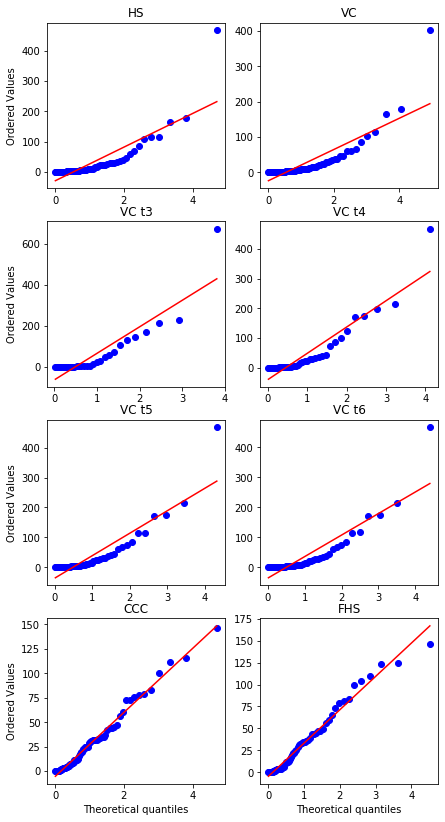

In [603]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=[7, 14])

for name, axis in zip(viol_97.columns, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]):
    spacings = viol_97[name].groupby(viol_97[name].cumsum()).cumcount(ascending=False)[viol_97[name]]
    probplot(spacings, dist="expon", plot=axis)
    axis.set_title('{}'.format(name))

[axis.set_xlabel('') for axis in [ax1, ax2, ax3, ax4, ax5, ax6]]
[axis.set_ylabel('') for axis in [ax2, ax4, ax6, ax8]]

plt.savefig('spacings_97.png', dpi=150)
plt.show()

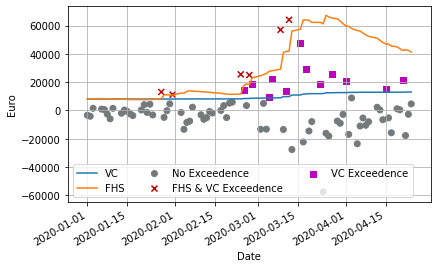

In [806]:
# ax = var_97['2020-04-01':].reset_index().plot()
# real_losses['2020-04-01':].plot.bar(ax=ax)
# real_losses
var_2020 = var_97['2020-01-01':][['VC', 'FHS']] * 1000000
loss_2020 = real_losses['2020-01-01':] * 1000000

ax = var_2020.plot(figsize=(6.5, 4), grid=True)
c = []
for idx in var_2020.index.date:
    idx = idx.strftime('%Y-%m-%d')
    if loss_2020.loc[idx, 'Losses'] > var_2020.loc[idx, 'FHS']:
        c.append('#BB0000')
    elif loss_2020.loc[idx, 'Losses'] > var_2020.loc[idx, 'VC']:
        c.append('#BB00BB')
    else:
        c.append('#74797c')
c = np.array(c, dtype='object')
labels = {
    '#BB00BB': 'VC Exceedence',
    '#74797c': 'No Exceedence',
    '#BB0000': 'FHS & VC Exceedence'
}
markers = {'#BB0000': 'x', '#74797c': 'o', '#BB00BB': 's'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        loss_2020.index[sel],
        loss_2020.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
plt.ylabel('Euro')
ax.legend(frameon=True, ncol=3)
plt.savefig('var.png', dpi=150)
plt.show()


In [751]:
for idx in var_2020.index.date:
    print(idx)

2020-01-01
2020-01-02
2020-01-03
2020-01-06
2020-01-07
2020-01-08
2020-01-09
2020-01-10
2020-01-13
2020-01-14
2020-01-15
2020-01-16
2020-01-17
2020-01-20
2020-01-21
2020-01-22
2020-01-23
2020-01-24
2020-01-27
2020-01-28
2020-01-29
2020-01-30
2020-01-31
2020-02-03
2020-02-04
2020-02-05
2020-02-06
2020-02-07
2020-02-10
2020-02-11
2020-02-12
2020-02-13
2020-02-14
2020-02-17
2020-02-18
2020-02-19
2020-02-20
2020-02-21
2020-02-24
2020-02-25
2020-02-26
2020-02-27
2020-02-28
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-29
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-05
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-12
2020-04-13
2020-04-14
2020-04-15
2020-04-16
2020-04-17
2020-04-19
2020-04-20
2020-04-21
2020-04-22
2020-04-23
2020-04-24


In [851]:
vars_97 = np.empty(3)
vars_99 = np.empty(300)
ess_97 = np.empty(300)
ess_99 = np.empty(300)

vars_97[:] = np.nan
vars_99[:] = np.nan
ess_97[:] = np.nan
ess_99[:] = np.nan

for t in range(324, 0, -1):
    mean, std = vc(X[t+100:450])
    vars_97[t] = normal_var(mean, std, 0.975) * 1000000
    vars_99[t] = normal_var(mean, std, 0.99) * 1000000
    
    ess_97[t] = normal_es(mean, std, 0.975) * 1000000
    ess_99[t] = normal_es(mean, std, 0.99) * 1000000

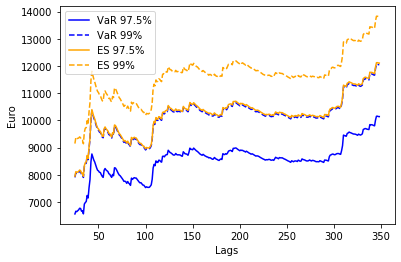

In [852]:
lags = list(range(25, 350))
plt.plot(lags, vars_97[::-1], label='VaR 97.5%', color='b')
plt.plot(lags, vars_99[::-1], '--', label='VaR 99%', color='b')
plt.plot(lags, ess_97[::-1], label='ES 97.5%', color='orange')
plt.plot(lags, ess_99[::-1], '--', label='ES 99%', color='orange')
plt.legend()
plt.ylabel('Euro')
plt.xlabel('Lags')
plt.savefig('vc_length_sensitivity.png', dpi=150)

In [847]:
real_losses.iloc[450]

Losses   -0.002393
Name: 2011-03-27, dtype: float64

In [ ]:
real_losses['']